## Bayesian linear regression (known error precision)

###### Assumptions: polynomial basis functions, scalar output, scalar input, error precision known
###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, math, sys

#### Model definition (basis functions)

In [2]:
N = 2 # number of basis
def basisFun(Xin,ith):
    if ith==0: return np.sin(10.0*Xin)
    elif ith==1: return -np.sin(0.65*Xin)
    

#### True coefficients and error precision (If known)

In [3]:
trueKnown =1 # 0 = dont plot true, 1= plot true 
Wtrue=[0]*N
Wtrue[0]=1
Wtrue[1]=0 
RHOtrue = 500

#### Known parameters

In [4]:
m0 = np.ones(N)*0 # prior mean
P0 = np.diag([1e+01]*N) # prior covariance
RHO = RHOtrue # initial error precision
#pl.rcParams.update({'font.size':14})

#### Generate design matrix 

In [5]:
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Phi = np.zeros((M,N))
for i in range(0,M):
    for j in range(0,N):
        Phi[i,j] = basisFun(Xobs[i],j)

#### Bayesian linear regression update

In [6]:
GAMinv = np.identity(M)*RHO
P0inv = la.inv(P0)
PMLEinv = np.matmul(np.matmul(np.transpose(Phi),GAMinv),Phi)
Wmle = np.matmul(np.matmul(np.matmul(la.inv(PMLEinv),np.transpose(Phi)),GAMinv),Yobs)
Pinv = P0inv + PMLEinv
P = la.inv(Pinv) 
m = np.matmul(P,np.matmul(P0inv,m0) + np.matmul(PMLEinv,Wmle))
B = np.matmul(Phi,np.matmul(P0,np.transpose(Phi))) + la.inv(GAMinv)
logEvid = np.log(st.multivariate_normal.pdf(Yobs,np.matmul(Phi,m0),B))
u1,s1,v1 = la.svd(PMLEinv)
u2,s2,v2 = la.svd(Pinv)
resNormMLE = la.norm(Yobs-np.matmul(Phi,Wmle))
resNormMAP = la.norm(Yobs-np.matmul(Phi,m))

In [7]:
print(' i   Wprior     Wmle      Wmap   PRECprior   PRECmle   PRECmap  SVD(PRECmle) SVD(PRECmap)')
for i in range(0,N):
    print("{0:2d}{1:10.2e}{2:10.2e}{3:10.2e}{4:10.2e}{5:10.2e}{6:10.2e}{7:12.2e}{8:12.2e}".format(\
        int(i),m0[i],Wmle[i],m[i],P0inv[i,i],PMLEinv[i,i],Pinv[i,i],s1[i],s2[i]))
print("\n           Cond no.   Rank")
print("PRECmle: {0:10.2e}{1:5d}/{2:2d}".format(la.cond(PMLEinv), la.matrix_rank(PMLEinv),N))
print("PRECmap: {0:10.2e}{1:5d}/{2:2d}".format(la.cond(Pinv), la.matrix_rank(Pinv),N))
print("\nLogEvid: {0:12.2e}\nRho: {1:16.2e}".format(logEvid,RHO))
print("ResNormMLE: {0:9.2e}\nResNormMAP: {1:9.2e}".format(resNormMLE,resNormMAP))

 i   Wprior     Wmle      Wmap   PRECprior   PRECmle   PRECmap  SVD(PRECmle) SVD(PRECmap)
 0  0.00e+00 -1.01e-02 -1.01e-02  1.00e-01  4.68e+03  4.68e+03    4.81e+03    4.81e+03
 1  0.00e+00  9.84e-01  9.84e-01  1.00e-01  4.44e+03  4.44e+03    4.31e+03    4.31e+03

           Cond no.   Rank
PRECmle:   1.12e+00    2/ 2
PRECmap:   1.12e+00    2/ 2

LogEvid:     1.82e+01
Rho:         5.00e+02
ResNormMLE:  2.25e-01
ResNormMAP:  2.25e-01


#### Plot parameter marginal pdfs

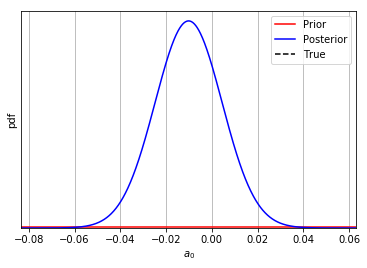

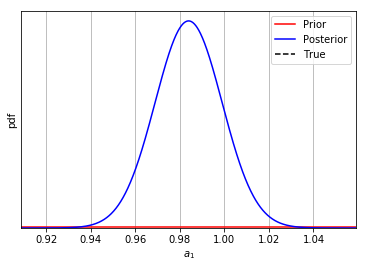

In [10]:
Wlim = [-6,6]  # xlim for plotting pdf plots
Ngrid = 1000  # density for grid generation in X
pscale=5  # for automatic bound calculation for pdf plots 
for i in range(0,N):
    Wpriormin = m0[i]-pscale*np.sqrt(P0[i,i])
    Wpriormax = m0[i]+pscale*np.sqrt(P0[i,i])
    Wpostmin = m[i]-pscale*np.sqrt(P[i,i])
    Wpostmax = m[i]+pscale*np.sqrt(P[i,i])
    Wlim = [min(Wpriormin,Wpostmin),max(Wpostmax,Wpriormax)] 
    Wlim = [Wpostmin,Wpostmax] 
    Wgrid = np.linspace(Wlim[0],Wlim[1],Ngrid)
    Wprior = st.multivariate_normal.pdf(Wgrid,m0[i],(P0[i,i]))
    Wpost = st.multivariate_normal.pdf(Wgrid,m[i],(P[i,i]))
    fig = plt.figure(i+1)
    plt.plot(Wgrid,Wprior,'r-',label='Prior')
    plt.plot(Wgrid,Wpost,'b-',label='Posterior')
    plt.grid(True); plt.yticks([]); plt.xlim(Wlim)
    ax = plt.gca(); Ylim = ax.get_ylim()
    if trueKnown == 1: plt.plot([Wtrue[i],Wtrue[i]],[0,Ylim[1]],'k--',label='True')
    plt.ylim([0,Ylim[1]])
    plt.xlabel(r'$a_{'+str(i)+'}$')
    plt.ylabel('pdf')
    plt.legend(loc='best', numpoints = 1)
    plt.savefig('1_BLR_mpdf'+str(i)+'.eps',bbox_inches='tight')    

#### Plot model predictions vs true response

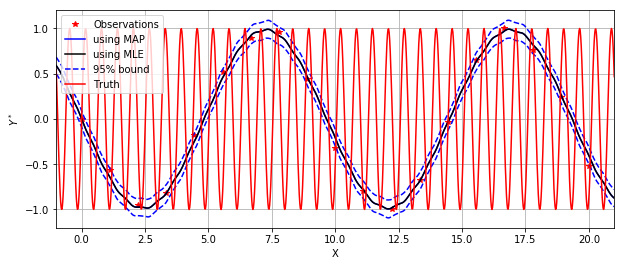

In [13]:
Xextra = 1 # width for extrapolation
Yrnge = [-2,10] 
Mnew = 1000
Xrnge = [min(Xobs)-Xextra,max(Xobs)+Xextra]
Xnew = np.linspace(Xrnge[0],Xrnge[1],Mnew)
PhiNew = np.zeros((Mnew,N))
for i in range(0,Mnew):
    for j in range(0,N):
        PhiNew[i,j] = basisFun(Xnew[i],j)
Yvar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/RHO
Ymap = np.matmul(PhiNew,m)
Ymle = np.matmul(PhiNew,Wmle)
fig = plt.figure(N+1,figsize=(10,4))
plt.plot(Xobs,Yobs,'r*',label='Observations')
plt.plot(Xnew,Ymap,'b-',label='using MAP')
plt.plot(Xnew,Ymle,'k-',label='using MLE')
plt.plot(Xnew,Ymap+2*np.sqrt(np.diag(Yvar)),'b--',label='95% bound')
plt.plot(Xnew,Ymap-2*np.sqrt(np.diag(Yvar)),'b--')
if trueKnown ==1:
    Ytrue = np.matmul(PhiNew,np.transpose(Wtrue))
    plt.plot(Xnew,Ytrue,'r-',label='Truth')
plt.grid(True)
plt.ylabel(r'$Y^*$')
plt.xlabel('X')
#plt.ylim(Yrnge)
plt.xlim([Xrnge[0],Xrnge[1]])
plt.legend(loc='best', numpoints = 1)
plt.savefig('1_BLR_pred.eps',bbox_inches='tight')